In [16]:
import faker
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import pandas as pd

Data story
- x sales_reps
- y products with different prices
- each sales_rep sells 

### Utility functions

In [108]:
def make_email(name_first, name_last):
    '''Generates Email-Adresses for names'''
    email = []
    for first, last in zip(name_first, name_last):
        first, last = first.lower(), last.lower()
        if " " in first: first = "_".join(first.split(" "))
        if " " in last: last = "_".join(last.split(" "))
        
        email.append(f"{first}.{last}@{fake.free_email_domain()}")
        
    return email


    

### Data generation

In [330]:
np.random.seed(123)

## Initialize Faker
fake = faker.Faker('de_DE')
fake.seed_instance(456)

### Assumptions    ###
######################
n_sales_reps = 5 # Number of sales people
p_sales_rep = np.repeat(1/n_sales_reps, n_sales_reps) # Probability of sell per sales rep (default: equal probability)
trend_sales_rep = [3,3,2,1.5, 1.2] # Trend factor (3x beginning sales) MUST EQUAL LENGTH OF n_sales_reps
n_products = 6 # Number of different products
price_range = [10,50]
n_transactions = 10_000 # Number of transactions in total
n_units = np.arange(2, 50)
start, end = pd.to_datetime("09-01-2022"), pd.to_datetime("09-30-2022") # Start and end date of data set
good_rep = 3 # Sales name that has better weekend units

### Generated data ###
######################
price_product = np.round(np.random.uniform(low=price_range[0], high=price_range[1],size=n_products), 2)
id_product = np.arange(1,n_products+1)
product_2_price = {p_id:price for p_id, price in zip(id_product,price_product )}

names_reps = [fake.name() for _ in range(n_sales_reps)]
name_first_customer = [fake.first_name() for _ in range(n_transactions)]
name_last_customer = [fake.last_name() for _ in range(n_transactions)]
email_customer = make_email(name_first_customer, name_last_customer)
product_ids = np.random.choice(id_product, size=n_transactions)
rep_per_sale = np.random.choice(names_reps, size=n_transactions, p=p_sales_rep)
units_per_sale = np.random.choice(n_units, size=n_transactions)
iban_customer = [fake.iban() for _ in range(n_transactions)]
address = [fake.address() for _ in range(n_transactions)]
street = [el.split("\n")[0] for el in address]
city = [el.split("\n")[1] for el in address]
plz = [el.split(" ")[0] for el in city]

dates = [fake.date_between_dates(start, end) for _ in range(n_transactions)]
dates = np.sort(dates)

### Aggregate data to dataframe

In [379]:
data = {
        "Name1": name_first_customer, 
        "Name2": name_last_customer, 
        "iban": iban, 
        "email": email_customer, 
        "Straße": street,
        "Ort": city,
        "plz": plz, 
        "Produkt-Nr.": product_ids, 
        "Menge": units_per_sale,
        "Vertriebler": rep_per_sale,     
        }
df_prelim = (pd.DataFrame(data)
             .assign(Preis=df_prelim["Produkt-Nr."].replace(product_2_price))
            )
df_prelim.head()

,Name1,Name2,iban,email,Straße,Ort,plz,Produkt-Nr.,Menge,Vertriebler,Preis
0,Ferdi,Hartung,DE34796286062975654221,ferdi.hartung@aol.de,Börnerplatz 3,45618 Badibling,45618,2,2,Wilhelmine Mosemann MBA.,21.45
1,Hans-Hermann,Hande,DE22626842179639432480,hans-hermann.hande@gmx.de,Hüseyin-Kroker-Ring 0/8,80052 Eisenhüttenstadt,80052,1,33,August Nerger,37.86
2,Hans-Georg,Schulz,DE34511043662155749418,hans-georg.schulz@googlemail.com,Trubstraße 860,31611 Worbis,31611,2,34,Gottlieb Noack,21.45
3,Janette,Berger,DE79551058218017945882,janette.berger@gmail.com,Klaus-D.-Neuschäfer-Weg 9/0,38005 Gifhorn,38005,2,32,Reinhilde Seip-Benthin,21.45
4,Reinhart,Bender,DE71144184102579774345,reinhart.bender@gmail.com,Dorothea-Striebitz-Gasse 3,13989 Grimma,13989,1,10,Reinhilde Seip-Benthin,37.86


### Add data story

In [380]:
def add_trend(col_data):
    t_max = np.random.choice(trend_sales_rep)
    n = len(col_data)
    trend = np.linspace(1,t_max, num=n)
    e = np.random.rand(n) * 200
    res = np.maximum(trend * col_data.sort_values() + e, 1)
    return res

In [382]:
df = (df_prelim
      .assign(Menge=lambda _df: _df.groupby("Vertriebler")["Menge"].transform(add_trend), # Add general trend to "Menge"
              Datum=pd.to_datetime(dates).dat)
      .assign(Menge=lambda _df: np.where((_df["Datum"].dt.weekday == 5) | (_df["Datum"].dt.weekday == 6), _df["Menge"] * 0.5, _df["Menge"])) # Add negative weekend trend
      .assign(Menge=lambda _df: np.where(((_df["Datum"].dt.weekday == 5) | (_df["Datum"].dt.weekday == 6)) & (_df["Vertriebler"] == names_reps[good_rep - 1]), _df["Menge"] * 1.8, _df["Menge"])) # Add good sales guy weekend upswing
      .assign(Menge=lambda _df: np.where((_df["plz"].str.startswith(r"8") | _df["plz"].str.startswith("9")), _df["Menge"] * 1.49, _df["Menge"])) # Add upswing for Region 8 and 9
      .assign(Umsatz=lambda _df: np.round(_df["Menge"] * _df["Preis"], 2))
      .reset_index(drop=True)
      .astype({"Menge": int})
     )
df.head()

,Name1,Name2,iban,email,Straße,Ort,plz,Produkt-Nr.,Menge,Vertriebler,Preis,Datum,Umsatz
0,Ferdi,Hartung,DE34796286062975654221,ferdi.hartung@aol.de,Börnerplatz 3,45618 Badibling,45618,2,123,Wilhelmine Mosemann MBA.,21.45,2022-09-01,2659.46
1,Hans-Hermann,Hande,DE22626842179639432480,hans-hermann.hande@gmx.de,Hüseyin-Kroker-Ring 0/8,80052 Eisenhüttenstadt,80052,1,207,August Nerger,37.86,2022-09-01,7846.61
2,Hans-Georg,Schulz,DE34511043662155749418,hans-georg.schulz@googlemail.com,Trubstraße 860,31611 Worbis,31611,2,5,Gottlieb Noack,21.45,2022-09-01,125.95
3,Janette,Berger,DE79551058218017945882,janette.berger@gmail.com,Klaus-D.-Neuschäfer-Weg 9/0,38005 Gifhorn,38005,2,50,Reinhilde Seip-Benthin,21.45,2022-09-01,1091.67
4,Reinhart,Bender,DE71144184102579774345,reinhart.bender@gmail.com,Dorothea-Striebitz-Gasse 3,13989 Grimma,13989,1,183,Reinhilde Seip-Benthin,37.86,2022-09-01,6941.90


In [385]:
pd.to_datetime(dates).date

array([datetime.date(2022, 9, 1), datetime.date(2022, 9, 1),
       datetime.date(2022, 9, 1), ..., datetime.date(2022, 9, 29),
       datetime.date(2022, 9, 29), datetime.date(2022, 9, 29)],
      dtype=object)

## Summary of story

__Story 1__
- general increasing trend of units (not prices) over time
- leads to increase in sales over time

__Story 2__
- sales during weekends significantly worse (~50% less)
- but: one sales person does not have dip over weekend 

__Story 3__
- regions are build by first number of plz
- regions starting with 8 and 9 are better


## Save data per region

In [362]:
for n,group in df.groupby(df["plz"].str[0]):
    fname = f"Region_{n}.xlsx"
    group.to_excel(fname)
    

In [ ]:
df.groupby(df["Datum"

In [82]:
## Generate transaction data
transactions_per_sales = [300, 200, 250, 250]
n_sales_reps = len(transactions_per_sales)
n_sales = sum(transactions_per_sales)
product_ids, prices = [1,2,3,4,5,6], [12.99, 41.23, 45.89, 123.39, 987.45, 3.45]
id2price = {p_id:price for p_id, price in zip(product_ids,prices )}
sales = [fake.name() for _ in range(n_sales_reps)]

name_first = [fake.first_name() for _ in range(n_sales)]
name_last = [fake.last_name() for _ in range(n_sales)]

email = []
for first, last in zip(name_first, name_last):
    first, last = first.lower(), last.lower()
    if " " in first: first = "_".join(first.split(" "))
    if " " in last: last = "_".join(last.split(" "))
        
    email.append(f"{first}.{last}@{fake.free_email_domain()}")


products = np.random.choice(product_ids, size=n_sales)
rep_per_sale = np.random.choice(sales, size=n_sales, p=np.array(transactions_per_sales)/n_sales)
units = np.random.randint(1,10,size=n_sales)
iban = [fake.iban() for _ in range(n_sales)]

start, end = pd.to_datetime("09-01-2022"), pd.to_datetime("09-30-2022")
dates = [fake.date_between_dates(start, end) for _ in range(n_sales)]

In [83]:
data = {
      "Datum": dates,
      "Name1": name_first, 
      "Name 2": name_last, 
      "i_ban": iban, 
      "email": email, 
      "product_id":products,
      "Menge": units,
      "Vertriebler": rep_per_sale}

In [88]:
df = (pd.DataFrame(data)
      .assign(#Preis=lambda _df: _df["product_id"].replace(id2price), 
              Datum=lambda _df: pd.to_datetime(_df["Datum"]).dt.normalize(), 
              Wochentag=lambda _df: _df["Datum"].dt.weekday, 
              Menge=lambda _df: _df.groupby(["Vertriebler"])["Menge"].transform(add_trend, 50).astype(int),
              Menge2=lambda _df: _df.where(~((_df["Datum"].dt.weekday == 5) & (_df["Vertriebler"] == sales[0]) | (_df["Datum"].dt.weekday == 6) & (_df["Vertriebler"] == sales[0])), #(_df["Datum"].dt.weekday != 6) ,
                                             _df["Menge"] * np.random.choice([2,3,4,5], size=n_sales), axis=0)["Menge"], 
      )
      .sort_values(by="Datum")
      .reset_index(drop=True)
     )

df.head()

,Datum,Name1,Name 2,i_ban,email,product_id,Menge,Vertriebler,Wochentag,Menge2
0,2022-09-01,Gottfried,Bolnbach,DE02356997736507384909,gottfried.bolnbach@yahoo.de,6,163,Ing. Babett Bender,3,163
1,2022-09-01,Paul,Kade,DE08849018037397452658,paul.kade@hotmail.de,2,41,Frank-Peter Christoph,3,41
2,2022-09-01,Rainer,Mitschke,DE97323855202838027068,rainer.mitschke@yahoo.de,3,37,Ing. Babett Bender,3,37
3,2022-09-01,Ljiljana,Rust,DE89533286549106605720,ljiljana.rust@aol.de,2,41,Ing. Babett Bender,3,41
4,2022-09-01,Susan,Rogner,DE77094227579519156690,susan.rogner@gmx.de,3,184,Ing. Babett Bender,3,184


In [81]:
def add_trend(group, top=2):
    '''Adds Trend to specific Column
    
    - use with groupby.transform!
    
    '''
    n = len(group)
    trend = np.maximum(np.linspace(1,top,n) + np.random.randn(n)/5, 1)
    menge = trend * group
    return menge
    

<ipython-input-91-f9b46211827b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=10)


[Text(19236.0, 0, ''),
 Text(19240.0, 0, ''),
 Text(19244.0, 0, ''),
 Text(19248.0, 0, ''),
 Text(19252.0, 0, ''),
 Text(19256.0, 0, ''),
 Text(19260.0, 0, ''),
 Text(19264.0, 0, '')]

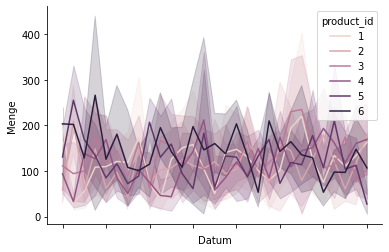

In [91]:
person = "Kathrin Rose-Kade"#"Frank-Peter Christoph"
ax = sns.lineplot(data=df, x="Datum", y="Menge", hue="product_id")
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)

<AxesSubplot:xlabel='Datum', ylabel='Menge_cum'>

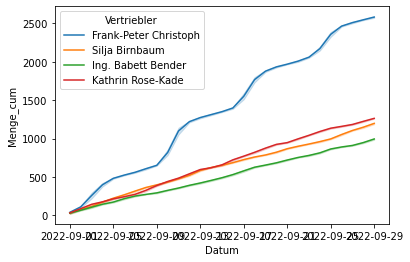

In [45]:
df_new = (df
         .groupby("Vertriebler")
         .apply(lambda gdf: (gdf
                            .assign(Menge_cum=lambda _df: _df["Menge"].cumsum())
                            )
         )
         .sort_values(by="Datum")
         .reset_index(drop=True)     
 )
sns.lineplot(data=df_new, x="Datum", y="Menge_cum", hue="Vertriebler")

In [54]:
person = sales[1]
df.query("Vertriebler == @person").groupby("Datum").agg({"Menge2": np.mean})

,Menge2
Datum,
2022-09-01,22.100000
2022-09-02,24.400000
2022-09-03,43.200000
2022-09-04,32.333333
2022-09-05,28.375000
2022-09-06,29.555556
2022-09-07,23.000000
2022-09-08,15.500000
2022-09-09,29.000000


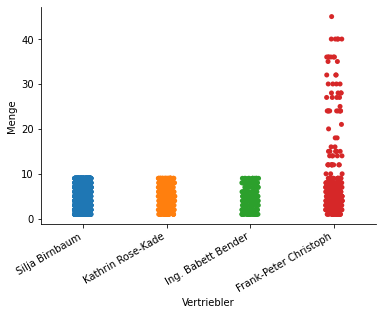

In [154]:
ax = sns.stripplot(data=df, x="Vertriebler",y="Menge", );
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
sns.despine()

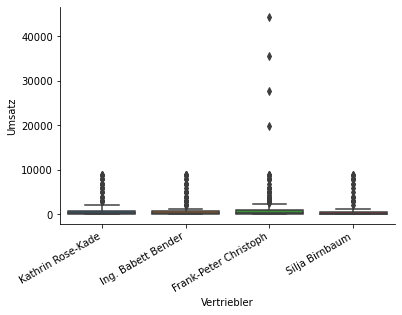

In [128]:
ax = sns.boxplot(data=df, x="Vertriebler", y="Umsatz" )#hue="Vertriebler")


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

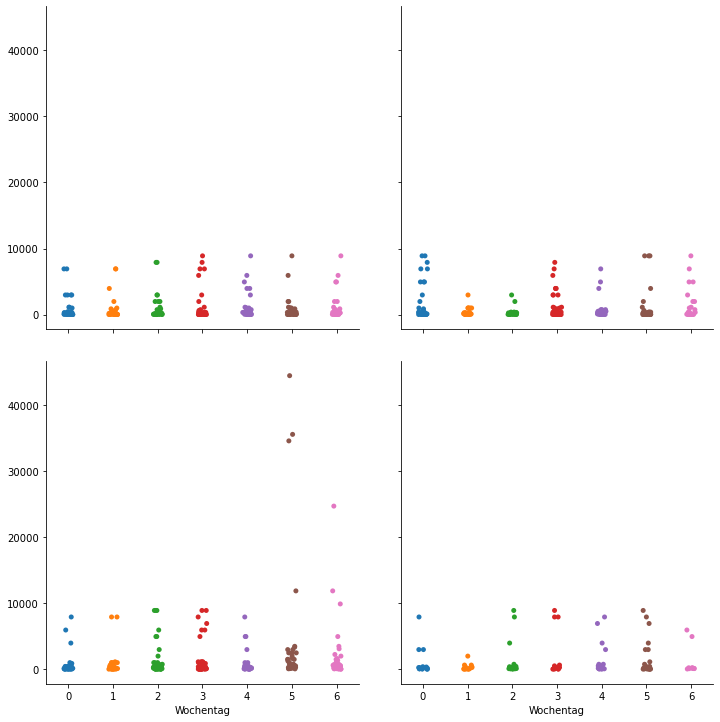

In [115]:
ax = sns.catplot(data=df, x="Wochentag", y=df["Menge"] * df["Preis"], col="Vertriebler", col_wrap=2, )
ax.tight_layout()
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle("Sales by Rep and Weekday")

In [257]:
# Save per day
for name,group in df.groupby("Datum"):
    print(name)
    group.to_excel(f"chapters/assets/datasets/sales/{name.date()}_Sales.xlsx")

2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00
2022-09-04 00:00:00
2022-09-05 00:00:00
2022-09-06 00:00:00
2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00
2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00
2022-09-13 00:00:00
2022-09-14 00:00:00
2022-09-15 00:00:00
2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00
2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00
2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00
